In [1]:
pip install pyscf

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pylatexenc

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install qiskit-nature

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.opflow import StateFn
from scipy.optimize import minimize
from qiskit.visualization import *
from qiskit import BasicAer
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import TwoLocal, RealAmplitudes, ZZFeatureMap
from qiskit.circuit import Parameter, ParameterVector
import random
import math


/var/folders/mt/flzd4_6j3ngc66xzbqsfrt500000gn/T/ipykernel_24979/662497906.py:6: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import StateFn


In [5]:
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit_nature.algorithms import ExcitedStatesEigensolver
from qiskit_nature.algorithms import NumPyEigensolverFactory
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

/var/folders/mt/flzd4_6j3ngc66xzbqsfrt500000gn/T/ipykernel_24979/437883609.py:4: NatureDeprecationWarning: The qiskit_nature.algorithms.excited_state_solvers package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.algorithms.excited_state_solvers package.
  from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
/var/folders/mt/flzd4_6j3ngc66xzbqsfrt500000gn/T/ipykernel_24979/437883609.py:4: NatureDeprecationWarning: The qiskit_nature.algorithms.pes_sampler package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release . Please refer to 'https://github.com/Qiskit/qiskit-nature/issues/750' for additional information regarding 'extrapolators'.
  from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory


In [6]:
def encode(num_qubits, bl):
	qr_m = QuantumRegister(num_qubits , 'qr_m') # for the main part - ansatz - Hc
	cr_nn = ClassicalRegister(num_qubits, 'cr_nn') # for classical collapse and intialisation
	
	qc = QuantumCircuit(qr_m,cr_nn)
	
	qc.h(qr_m)
	qc.ry(bl, qr_m)
 
	return qc


In [7]:
def apply_ansatz(qc, qr, params,reps):

    for i in range(0,reps):
        qc.cx(qr[0], qr[1])
        qc.ry(params[4*i], qr[0])
        qc.ry(params[4*i+1], qr[1])
        qc.cx(qr[1], qr[0])
        qc.ry(params[4*i+2], qr[0])
        qc.ry(params[4*i+3], qr[1])
        qc.barrier()

In [8]:
def NN_atom(num_qubits,bl,parameters, backend):
    '''
    num_qubits: number of qubits for neural network
    bl: bond length 
    parameters: the initial parameters
    '''
    qr_m = QuantumRegister(num_qubits , 'qr_m') # for the main part - ansatz - Hc
    cr_nn = ClassicalRegister(num_qubits, 'cr_nn') # for classical collapse and intialisation
    
    qc = QuantumCircuit(qr_m, cr_nn)
    
    # the number of parameters should be bigger than 4 and multiples of 8
    if len(parameters)%8 != 0:
         raise ValueError('Number of parameters should be multiples of 8')
            
    # defining all the parameters, we will be using a 2 layer neural network
    params_per_layer = int(len(parameters)/2)
    params1 = ParameterVector('θ1', params_per_layer)
    params2 = ParameterVector('θ2', params_per_layer)

    
    ## encoding
    qc_1 = encode(2,bl)
    qc = qc.compose(qc_1)
    
    ## First Layer
    reps_anastz = int(len(params1)/4)
    apply_ansatz(qc, qr_m, params1,reps_anastz)

    qc.measure(qr_m, cr_nn)

    qc = qc.bind_parameters({params1 : parameters[: params_per_layer]})

    job = backend.run(qc)
    result = job.result()

    ## calculation of expectation value 
    count_dict = result.data()['counts']
    total_count = sum(count_dict.values())
    c0 = 0
    c2 = 0
    c4 = 0
    c6 = 0
    if '0x0' in count_dict.keys():
        c0 = count_dict['0x0']
    if '0x2' in count_dict.keys():
        c2 = count_dict['0x2']
    if '0x4' in count_dict.keys():
        c4 = count_dict['0x4']
    if '0x6' in count_dict.keys():
        c6 = count_dict['0x6']
    m_0_p_0 = (c0 + c4)/total_count
    m_0_p_1 = (c2 + c6)/total_count
    m_1_p_0 = (c0 + c2)/total_count
    m_1_p_1 = (c4 + c6)/total_count

    # Second layer
    qc.reset(qr_m)
    qc.h(qr_m)
    qc.ry(np.pi*(m_0_p_0 - m_0_p_1), qr_m[0])
    qc.ry(np.pi*(m_1_p_0 - m_1_p_1), qr_m[1])
    
    apply_ansatz(qc, qr_m, params2,reps_anastz)
    qc = qc.bind_parameters({params2 : parameters[params_per_layer :]})
    
    
    return qc

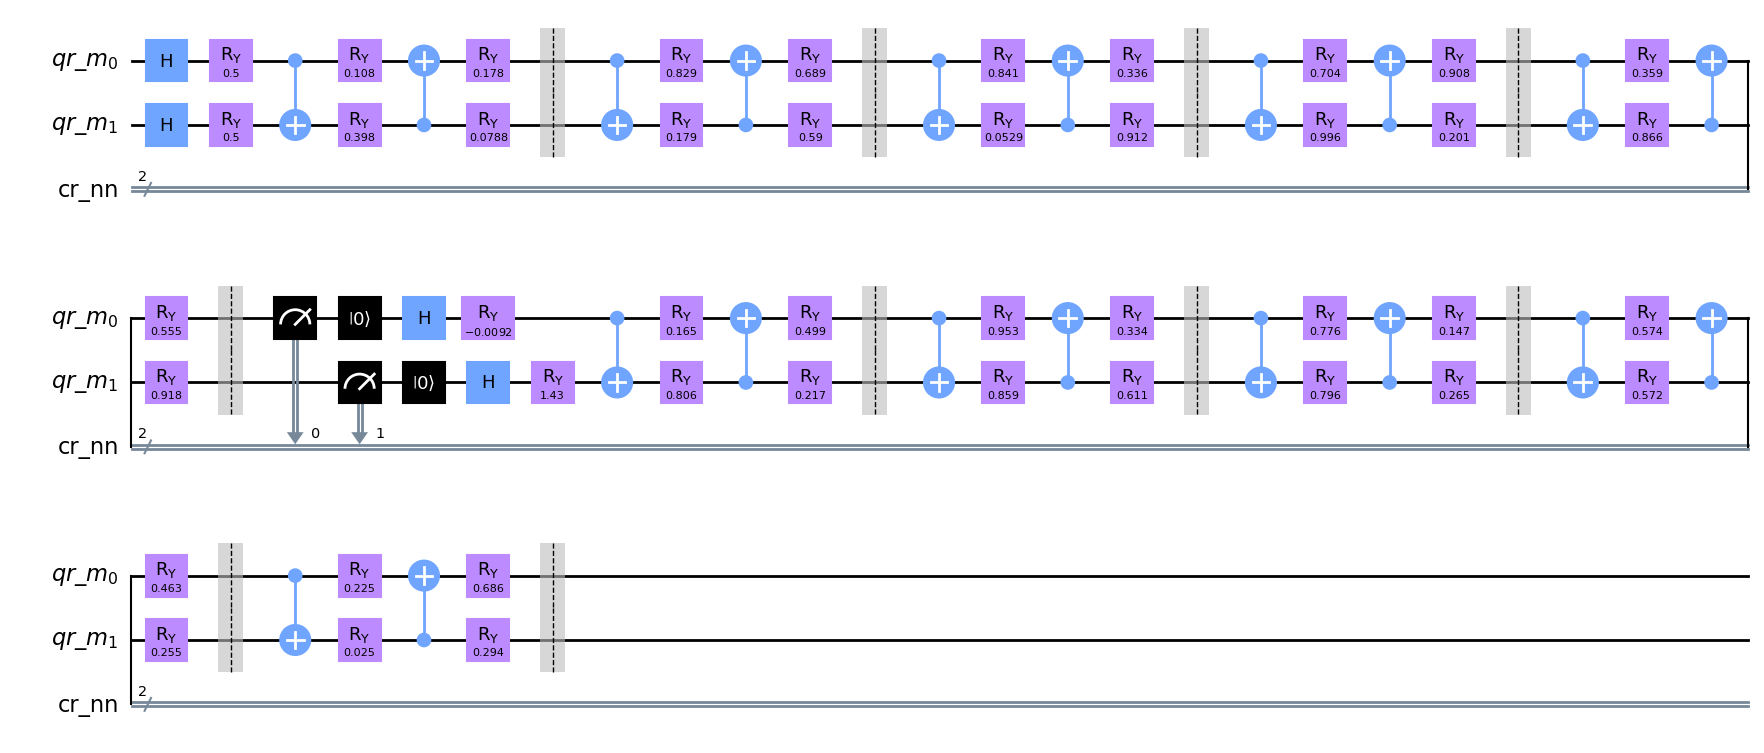

In [9]:
NN_atom(2,0.5,np.random.random(40),backend = Aer.get_backend('qasm_simulator')).draw(output='mpl')

In [10]:
pip install --prefer-binary pyscf

Note: you may need to restart the kernel to use updated packages.


In [11]:
def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

dist = np.arange(0.5,4,0.1)
exact_energy_arr = []
repulsion_energy_arr = []

for i in range(len(dist)):
    # defining of  the molecule
    molecule = "H .0 .0 .0; H .0 .0 " + str(dist[i]) 
    driver = PySCFDriver(atom=molecule)
    qmolecule = driver.run()
    
    # we define a problem using ElectronicStructureProblem
    problem = ElectronicStructureProblem(driver)
    
    # first we will calculate the repulsion energy classically 
    numpy_solver = NumPyEigensolverFactory(use_default_filter_criterion=True)
    converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)
    numpy_excited_states_calculation = ExcitedStatesEigensolver(converter, numpy_solver)
    numpy_results = numpy_excited_states_calculation.solve(problem)

    # our repulsion energy 
    repulsion_energy =numpy_results.nuclear_repulsion_energy
    
    
    # Generate the second-quantized operators
    second_q_ops = problem.second_q_ops()

    # Hamiltonian
    main_op = second_q_ops[0]
    mapper = ParityMapper()
    converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)

    # The fermionic operators are mapped to qubit operators
    num_particles = problem.num_particles
    qubit_op = converter.convert(main_op, num_particles=num_particles)
    
    result_exact = exact_diagonalizer(problem, converter)
    exact_energy = np.real(result_exact.eigenenergies[0])
    exact_energy_arr.append(exact_energy + repulsion_energy )
    repulsion_energy_arr.append(repulsion_energy)
    print("Exact electronic energy", exact_energy + repulsion_energy)
plt.plot(dist, exact_energy_arr)
plt.ylabel('Energy[Hartree]')
plt.xlabel('Atomic Separation[Angstrom]')
plt.show()

OSError: dlopen(/Applications/anaconda3/lib/python3.11/site-packages/pyscf/lib/libnp_helper.dylib, 0x0006): tried: '/Applications/anaconda3/lib/python3.11/site-packages/pyscf/lib/libnp_helper.dylib' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Applications/anaconda3/lib/python3.11/site-packages/pyscf/lib/libnp_helper.dylib' (no such file), '/Applications/anaconda3/lib/python3.11/site-packages/pyscf/lib/libnp_helper.dylib' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64'))

In [ ]:
import pyscf

In [ ]:
pip install pyscf

In [ ]:
pip install pyscf==v2.3.0